# Document Classifier

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from scipy.stats import uniform
import scipy.stats as stats
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import statsmodels.api as sm

In [3]:
# Load the data
df = pd.read_csv("data/a3_train_final.tsv", sep = "\t", names = ["y", "x"])
df_test = pd.read_csv("data/a3_test.tsv", sep = "\t", names = ["y", "x"])

# Drop potential nulls and duplicates
df.x = df.x.drop_duplicates()
df = df.dropna()

# df info
print(f"Test data shape: {df_test.shape}")
print(f"Training data shape: {df.shape}")
print(f"""Class distribution:
{df.value_counts('y')}""")
print(df.head())

Test data shape: (1524, 2)
Training data shape: (37882, 2)
Class distribution:
y                                          
1/1                                            14558
0/0                                            14167
0/-1                                            1881
1/-1                                            1584
1/0                                             1071
                                               ...  
0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0                  1
0/0/1/0/1                                          1
1/1/-1/0                                           1
1/1/0/0/0/0/1/0/0/0/0/1                            1
1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1        1
Length: 130, dtype: int64
          y                                                  x
0       1/1   I'll only consume if I know what's inside it....
1      0/-1   It is easier to fool a million people than it...
2       0/0   NATURAL IMMUNITY  protected us since evolutio...
3      0/-1   NA

In [4]:
# Take care of comments that are ambigous
def check_annotation(comment):
    """
    Check if all annotations are the same, if it is return given annotation else return ambigous.
    """
    set_comment = set(comment)

    if len(set_comment) == 2:
        return int(comment[0])
    else:
        return "ambigous"

df.y = df.y.apply(check_annotation)

# Check if it worked
print(f"""Value count before dropping ambigous: 
{df.y.value_counts()}""")

# Drop ambigous comment
df = df[df.y != "ambigous"]
print("-----------")

print(f"""Value count after dropping ambigous comments: 
{df.y.value_counts()}""")

Value count before dropping ambigous: 
1           15483
0           15201
ambigous     7198
Name: y, dtype: int64
-----------
Value count after dropping ambigous comments: 
1    15483
0    15201
Name: y, dtype: int64


Preprocessing - 

In [5]:
# Remove all symbols except those in the bracket
BAD_SYMBOLS_RE = re.compile('[^0-9a-z ]')

def clean_text(text):
    """ 
    Cleans a string of text...

    Parameters:
    -----------
    text: a string

    Returns
    -------
    Cleaned string of text
    """

    # Make text lowercase
    text = text.lower()

    # Remove unwanted symbols
    text = BAD_SYMBOLS_RE.sub("", text) 

    # Lemmatize every word in the text
    wnl = WordNetLemmatizer()
    clean_text = ""

    for word in text.split():
        clean_text += wnl.lemmatize(word) + " "
    
    return clean_text

# Apply the clean_text function to every row in df
df.x = df.x.apply(clean_text)
df_test.x = df_test.x.apply(clean_text)

# Check how it looks after cleaning
print(df.head())

   y                                                  x
0  1  ill only consume if i know whats inside it sti...
2  0  natural immunity protected u since evolution d...
6  1  vaccine take more than a year to develop this ...
7  0  yes im a trucker from usa and i wont get vacci...
9  1  out of anger people say stupid thing man is sp...


EDA -

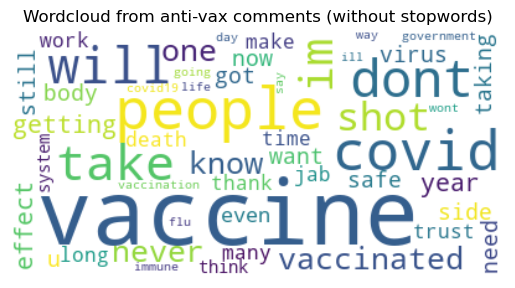

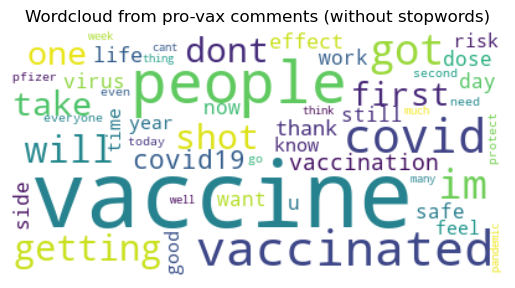

In [5]:
# Wordclouds
anti_vax = " ".join(word for word in df[df.y == 0].x)
pro_vax = " ".join(word for word in df[df.y == 1].x)

# Remove usual stopwords + some more neutral words commonly used for this dataset
stop_words = ["wa", "ha"] + list(STOPWORDS)

# Anti-vax
wordcloud_anti = WordCloud(collocations = False, background_color = "white", max_words = 50,
stopwords = stop_words).generate(anti_vax)
plt.axis("off")
plt.imshow(wordcloud_anti, interpolation = "bilinear")
plt.title("Wordcloud from anti-vax comments (without stopwords)")
plt.show()

# Pro-vax
wordcloud_pro = WordCloud(collocations = False, background_color = "white", max_words = 50,
stopwords = stop_words).generate(pro_vax)
plt.axis("off")
plt.imshow(wordcloud_pro, interpolation = "bilinear")
plt.title("Wordcloud from pro-vax comments (without stopwords)")
plt.show()

In [6]:
# Check which words occur the most in bigrams, trigrams... 
# get_ngrams function from:
# https://practicaldatascience.co.uk/machine-learning/how-to-use-count-vectorization-for-n-gram-analysis

def get_ngrams(text, ngram_from=2, ngram_to=2, n=None):
    """Count ngrams of a given text"""
    vec = CountVectorizer(ngram_range = (ngram_from, ngram_to), 
                        stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

    return words_freq[:n]

# Bigrams anti
bigrams_anti = get_ngrams(df[df.y == 0].x, ngram_from=2, ngram_to=2, n=10)
bigrams_anti_df = pd.DataFrame(bigrams_anti)
bigrams_anti_df.columns = ["Bigram", "Frequency"]

# Bigrams pro
bigrams_pro = get_ngrams(df[df.y == 1].x, ngram_from=2, ngram_to=2, n=10)
bigrams_pro_df = pd.DataFrame(bigrams_pro)
bigrams_pro_df.columns = ["Bigram", "Frequency"]

# Trigrams anti
trigrams_anti = get_ngrams(df[df.y == 0].x, ngram_from=3, ngram_to=3, n=10)
trigrams_anti_df = pd.DataFrame(trigrams_anti)
trigrams_anti_df.columns = ["Trigram", "Frequency"]

# Trigrams pro
trigrams_pro = get_ngrams(df[df.y == 1].x, ngram_from=3, ngram_to=3, n=10)
trigrams_pro_df = pd.DataFrame(trigrams_pro)
trigrams_pro_df.columns = ["Trigram", "Frequency"]

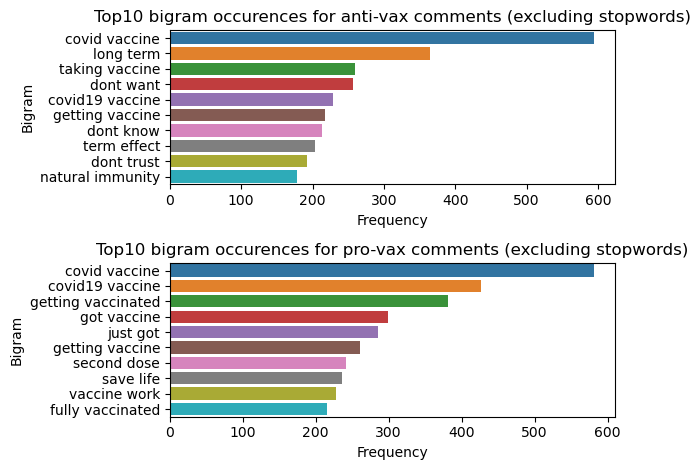

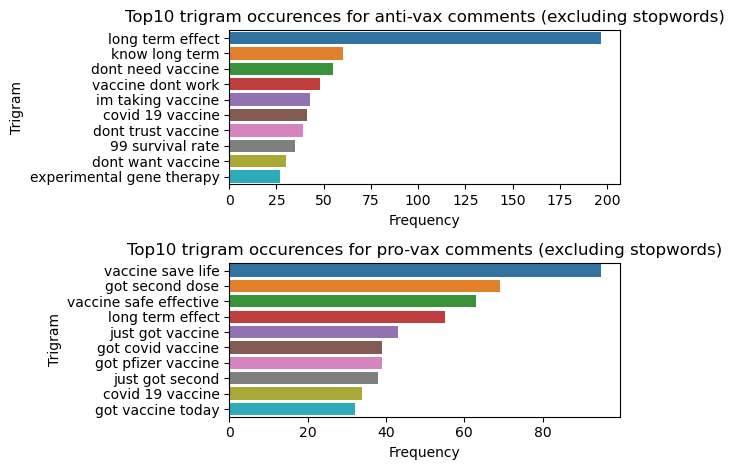

In [7]:
# Bigrams plot
fig, ax = plt.subplots(2,1)
sns.barplot(x = "Frequency", y = "Bigram", data = bigrams_anti_df, ax = ax[0]).set_title("Top10 bigram occurences for anti-vax comments (excluding stopwords)")
sns.barplot(x = "Frequency", y = "Bigram", data = bigrams_pro_df, ax = ax[1]).set_title("Top10 bigram occurences for pro-vax comments (excluding stopwords)")
plt.tight_layout()
plt.show()

# Trigrams plot
fig, ax = plt.subplots(2,1)
sns.barplot(x = "Frequency", y = "Trigram", data = trigrams_anti_df, ax = ax[0]).set_title("Top10 trigram occurences for anti-vax comments (excluding stopwords)")
sns.barplot(x = "Frequency", y = "Trigram", data = trigrams_pro_df, ax = ax[1]).set_title("Top10 trigram occurences for pro-vax comments (excluding stopwords)")
plt.tight_layout()
plt.show()

Modelling -

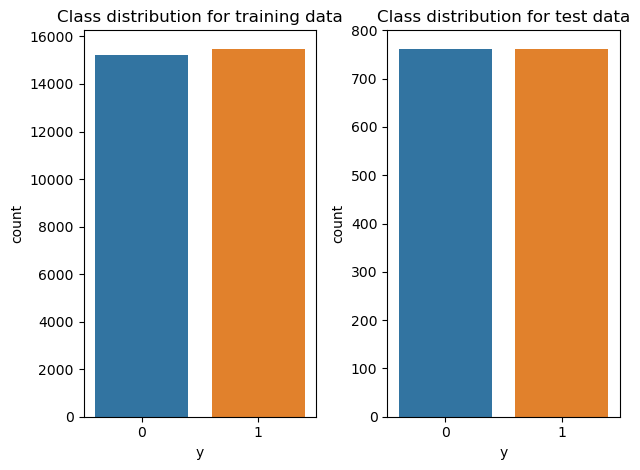

In [6]:
# Divide training data
X_train = df.x
y_train = df.y.astype("int")

# Divide test data
X_test = df_test.x
y_test = df_test.y.astype("int")

# Check if classes are balanced in training and test data
fig, ax = plt.subplots(1,2)
sns.countplot(x = y_train, ax = ax[0]).set_title("Class distribution for training data")
sns.countplot(x = y_test, ax = ax[1]).set_title("Class distribution for test data")
plt.tight_layout()
plt.show()

In [16]:
# Mnb default settings
mnb_pipe = make_pipeline(
    TfidfVectorizer(ngram_range = (1,2), min_df = 2),
    MultinomialNB())

# Fit the model
mnb_scores = cross_validate(mnb_pipe, X_train, y_train, cv = 5, scoring =("accuracy", "f1"), verbose = 0)
print(f"f1 scores during CV: {mnb_scores['test_f1']}")

# Print CV scores
print(f"""Mean f1 CV: {np.mean(mnb_scores['test_f1'])},
Mean accuracy CV: {np.mean(mnb_scores['test_accuracy'])}""")

f1 scores during CV: [0.85111042 0.83488906 0.83276116 0.83535188 0.82955282]
Mean f1 CV: 0.8367330667404943,
Mean accuracy CV: 0.8333983559655576


In [17]:
# Xgb model
xgb_pipe = make_pipeline(
    TfidfVectorizer(ngram_range = (1,2), min_df = 2),
    xgb.XGBClassifier())

# Fit the model
xgb_scores = cross_validate(xgb_pipe, X_train, y_train, cv = 5, scoring =("accuracy", "f1"), verbose = 0)
print(f"f1 scores during CV: {xgb_scores['test_f1']}")

# Print CV scores
print(f"""Mean f1 CV: {np.mean(xgb_scores['test_f1'])},
Mean accuracy CV: {np.mean(xgb_scores['test_accuracy'])}""")

f1 scores during CV: [0.80037518 0.78365157 0.78816729 0.77087442 0.7826087 ]
Mean f1 CV: 0.7851354312834883,
Mean accuracy CV: 0.785295360456028


In [18]:
"""# Hyperparameter tuning with randomized search
xgb_pipe = make_pipeline(
    TfidfVectorizer(ngram_range = (1,2), min_df = 2),
    xgb.XGBClassifier())

distributions = dict(xgbclassifier__learning_rate = uniform(loc = 0.3, scale = 1),
xgbclassifier__max_depth = randint(3, 9),
xgbclassifier__n_estimators = randint(100, 300))

xgb_clf = RandomizedSearchCV(xgb_pipe, param_distributions = distributions, n_iter = 50, scoring = "accuracy", cv = 5)

xgb_random_search = xgb_clf.fit(X_train, y_train)
print(xgb_random_search.best_params_)"""

'# Hyperparameter tuning with randomized search\nxgb_pipe = make_pipeline(\n    TfidfVectorizer(ngram_range = (1,2), min_df = 2),\n    xgb.XGBClassifier())\n\ndistributions = dict(xgbclassifier__learning_rate = uniform(loc = 0.3, scale = 1),\nxgbclassifier__max_depth = randint(3, 9),\nxgbclassifier__n_estimators = randint(100, 300))\n\nxgb_clf = RandomizedSearchCV(xgb_pipe, param_distributions = distributions, n_iter = 50, scoring = "accuracy", cv = 5)\n\nxgb_random_search = xgb_clf.fit(X_train, y_train)\nprint(xgb_random_search.best_params_)'

In [19]:
# Log.Reg model default settings
LR_pipe = make_pipeline(
    TfidfVectorizer(ngram_range = (1,2), min_df = 2),
    LogisticRegression(max_iter = 1000))

LR_scores = cross_validate(LR_pipe, X_train, y_train, cv = 5, scoring = ("accuracy", "f1"), verbose = 0)
print(f"f1 scores during CV: {LR_scores['test_f1']}")

print(f"""Mean f1 CV: {np.mean(LR_scores['test_f1'])},
Mean accuracy CV: {np.mean(LR_scores['test_accuracy'])}""")

f1 scores during CV: [0.8455259  0.82278285 0.82651007 0.83126632 0.83170573]
Mean f1 CV: 0.8315581736878489,
Mean accuracy CV: 0.829520335222757


In [20]:
# Random forest default settings
rf_pipe = make_pipeline(
    TfidfVectorizer(ngram_range = (1,2), min_df = 2),
    RandomForestClassifier())

rf_scores = cross_validate(rf_pipe, X_train, y_train, cv = 5, scoring = ("accuracy", "f1"), verbose = 0)

print(f"f1 scores during CV: {rf_scores['test_f1']}")

print(f"""Mean f1 CV: {np.mean(rf_scores['test_f1'])},
Mean accuracy CV: {np.mean(rf_scores['test_accuracy'])}""")

f1 scores during CV: [0.80653266 0.80156372 0.79017782 0.78710321 0.79079146]
Mean f1 CV: 0.7952337743165767,
Mean accuracy CV: 0.7957893791457504


In [21]:
# SVC (rbf) default settings
svc_pipe = make_pipeline(
    TfidfVectorizer(ngram_range = (1,2), min_df = 2),
    SVC())

svc_scores = cross_validate(svc_pipe, X_train, y_train, cv = 5, scoring = ("accuracy", "f1"), verbose = 2)

print(f"f1 scores during CV: {svc_scores['test_f1']}")

print(f"""Mean f1 CV: {np.mean(svc_scores['test_f1'])},
Mean accuracy CV: {np.mean(svc_scores['test_accuracy'])}""")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 7.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.6min remaining:    0.0s


[CV] END .................................................... total time= 7.9min
[CV] END .................................................... total time= 8.0min
[CV] END .................................................... total time= 8.9min
[CV] END .................................................... total time= 7.8min
f1 scores during CV: [0.85373509 0.83522286 0.83897881 0.84630414 0.84110032]
Mean f1 CV: 0.8430682438822567,
Mean accuracy CV: 0.8408290683032937


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 40.2min finished


In [22]:
# LinearSVC default settings
svc_pipe = make_pipeline(
    TfidfVectorizer(ngram_range = (1,2), min_df = 2),
    LinearSVC())

svc_scores = cross_validate(svc_pipe, X_train, y_train, cv = 5, scoring = ("accuracy", "f1"), verbose = 0)

print(f"f1 scores during CV: {svc_scores['test_f1']}")

print(f"""Mean f1 CV: {np.mean(svc_scores['test_f1'])},
Mean accuracy CV: {np.mean(svc_scores['test_accuracy'])}""")

f1 scores during CV: [0.85727744 0.83014729 0.84224466 0.84294041 0.84353741]
Mean f1 CV: 0.8432294435585966,
Mean accuracy CV: 0.840894331707626


In [ ]:
# f1 score with different vectorizer and over different ngram ranges
# Images saved for MnB and LinearSVC

# Tfidf ngram
tfidf_results = []
for i in range(6):
    # Mnb tfidf
    mnb_pipe = make_pipeline(
        TfidfVectorizer(ngram_range = (1,i+1), min_df = 2),
        MultinomialNB(alpha = 0.17))

    # Fit the model
    mnb_scores = cross_validate(mnb_pipe, X_train, y_train, cv = 5, scoring = "f1", verbose = 0)
    tfidf_results.append(np.mean(mnb_scores['test_score']))

# Count ngram
count_results = []
for i in range(6):
    # Mnb tfidf
    mnb_pipe = make_pipeline(
        CountVectorizer(ngram_range = (1,i+1), min_df = 2),
        MultinomialNB(alpha = 0.17))

    # Fit the model
    mnb_scores = cross_validate(mnb_pipe, X_train, y_train, cv = 5, scoring = "f1", verbose = 0)
    count_results.append(np.mean(mnb_scores["test_score"]))

# Plot results
ngram_range = np.arange(1,7)

sns.lineplot(x = ngram_range, y = tfidf_results, marker = "o", color = "blue", label = "Tf-IDF")
sns.lineplot(x = ngram_range, y = count_results[:6], marker = "o", color = "red", label = "Count")
plt.title("Multinomial naive Bayes f1 score over different ngram range")
plt.xlabel("ngram range")
plt.ylabel("f1 score")
plt.legend()
plt.show()

### Hyperparameter tuning

In [ ]:
# Create svc pipe to be used for random search
svc_pipe = make_pipeline(
    TfidfVectorizer(ngram_range = (1,2), min_df = 2),
    LinearSVC())

# Parameters to be tuned
distributions = dict(linearsvc__C = uniform(loc = 0, scale = 3))
# Random search
svc_clf = RandomizedSearchCV(svc_pipe, param_distributions = distributions, n_iter = 100, scoring = "f1", cv = 5)
# Fit the model
svc_random_search = svc_clf.fit(X_train, y_train)
# Print the best parameters
print(svc_random_search.best_params_)

In [ ]:
# Create mnb pipe to be used for random search
mnb_pipe = make_pipeline(
    TfidfVectorizer(ngram_range = (1,2), min_df = 2),
    MultinomialNB())

# Parameters to be tuned
distributions = dict(multinomialnb__alpha = uniform(loc = 0, scale = 3))
# Random search
mnb_clf = RandomizedSearchCV(mnb_pipe, param_distributions = distributions, n_iter = 100, scoring = "f1", cv = 5)
# Fit the model
mnb_random_search = mnb_clf.fit(X_train, y_train)
# Print the best parameters
print(mnb_random_search.best_params_)

### Comparing classifiers

In [7]:
# LinearSVC tuned settings
svc_pipe = make_pipeline(
    TfidfVectorizer(ngram_range = (1,2), min_df = 2),
    LinearSVC(C = 0.5))

svc_scores = cross_validate(svc_pipe, X_train, y_train, cv = 10, scoring = "f1", verbose = 0)

# Mnb tuned settings
mnb_pipe = make_pipeline(
    TfidfVectorizer(ngram_range = (1,2), min_df = 2),
    MultinomialNB(alpha = 0.17))

# Fit the model
mnb_scores = cross_validate(mnb_pipe, X_train, y_train, cv = 10, scoring = "f1", verbose = 0)

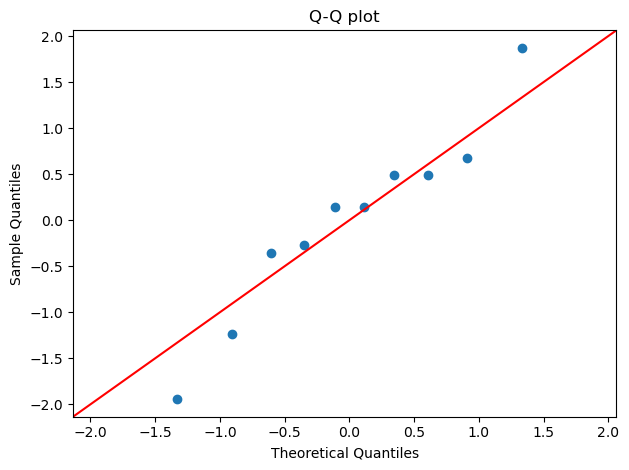

In [11]:
# Calculate the differences between our two samples of f1 score
f1_diffs = mnb_scores["test_score"] - svc_scores["test_score"]

# Plot Q-Q plot to see if the differences follow a Gaussian distribution
sm.qqplot(f1_diffs, line="45", fit = True)
plt.title("Q-Q plot")
plt.tight_layout()
plt.show()


In [12]:
# Run paired t-test on our two samples of f1 scores
paired_t = stats.ttest_rel(mnb_scores["test_score"], svc_scores["test_score"])
print(f"Paired t-test results: {paired_t}")

Paired t-test results: Ttest_relResult(statistic=-1.0043134811670418, pvalue=0.34146395592705253)


In [13]:
print(f"""Mean f1 score for MnB: {round(np.mean(mnb_scores["test_score"]),4)},
Mean f1 score for LinearSVC: {round(np.mean(svc_scores["test_score"]),4)}""")

Mean f1 score for MnB: 0.8419,
Mean f1 score for LinearSVC: 0.8457


### Run model on test data

In [8]:
# Fit model on all training data
svc_pipe.fit(X_train, y_train)
# Predict
y_pred = svc_pipe.predict(X_test)

# Print results
print(f"""Accuracy score on test data: {accuracy_score(y_test, y_pred)},
f1 score on test data: {f1_score(y_test, y_pred)}""")

Accuracy score on test data: 0.8838582677165354,
f1 score on test data: 0.883013879709187


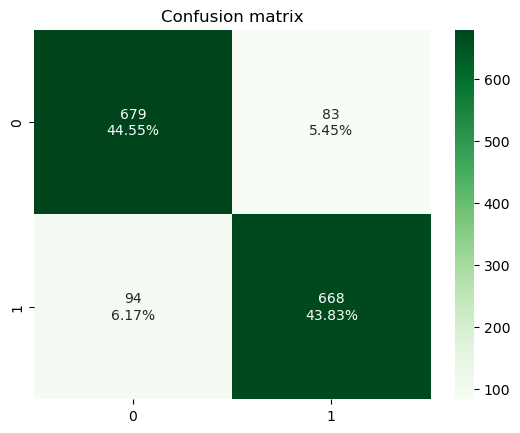

In [9]:
# Create Confusion Matrix
cf = confusion_matrix(y_test, y_pred)

group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
group_count = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
labels = [f"{v1}{v2}".strip() for v1,v2 in zip(group_count, group_percentages)]
labels = np.asarray(labels).reshape(cf.shape[0],cf.shape[1])

sns.heatmap(cf, annot = labels, fmt='', cmap = 'Greens').set(
    title = "Confusion matrix")
plt.show()

### Check some of the errors

In [12]:
def check_error(true, pred):
    results = []
    for i in range(len(true)):
        if true[i] == pred[i]:
            results.append("correct")
        elif true[i] == 1 and pred[i] == 0:
            results.append("FN")
        else:
            results.append("FP")

    return results

results = check_error(df_test.y, y_pred)
results

FP: FP
FN: FN


In [14]:
# Some examples
print(f"FP: {df_test.x[8]}")
print("------")
print(f"FN: {df_test.x[35]}")

FP: if you dont have the vaccine youre robbing someone else their right to live a healthy normal life lmfao my iq just dropped 10 point listening to that bullshit 
------
FN: a good friend is recovering after covid having refused vaccination he is confused and ha trouble focusing he remembers that he wasnt that way before a solid hit with covid leaf patient with an average of a seven iq point drop he isnt an average victim he young and healthy and he going to live with this damage for decade 
